## Setup and Imports

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

In [2]:
dataset_path = "datasets/FF++"
REAL_PATH = os.path.join(dataset_path, "real")
FAKE_PATH = os.path.join(dataset_path, "fake")
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10
MAX_VIDEOS = 200

def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    """Extract a fixed number of frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)  # uint8 numpy array
    cap.release()
    return frames if len(frames) == frame_count else None

# Collect data
data = []
labels = []

# Real videos
print("Processing real videos...")
for video_file in tqdm(os.listdir(REAL_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(0)  # 0 for real

# Fake videos
print("Processing fake videos...")
for video_file in tqdm(os.listdir(FAKE_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(1)  # 1 for fake

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

Processing real videos...


 16%|█▋        | 33/200 [00:21<01:49,  1.53it/s]


KeyboardInterrupt: 

## Data Augmentation and Dataset

In [ ]:
# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet norms
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VideoDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # List of frame sequences
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]  # List of frames
        label = self.labels[idx]
        sequence = [self.transform(frame) for frame in sequence]
        sequence = torch.stack(sequence)  # (10, 3, 128, 128)
        return sequence, label

# Create datasets
train_dataset = VideoDataset(X_train, y_train, train_transform)
val_dataset = VideoDataset(X_val, y_val, val_transform)
test_dataset = VideoDataset(X_test, y_test, val_transform)

# Create data loaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Model Architecture

In [ ]:
# class VideoClassifier(nn.Module):
#     def __init__(self):
#         super(VideoClassifier, self).__init__()
#         self.cnn = models.resnet18(pretrained=True)
#         self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])  # Remove last two layers
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # (512, 1, 1)
#         self.dropout1 = nn.Dropout(0.5)
#         self.lstm = nn.LSTM(512, 64, batch_first=True)  # Reduced units
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc = nn.Linear(64, 1)  # Single output
    
#     def forward(self, x):
#         batch_size, seq_len, C, H, W = x.size()
#         x = x.view(batch_size * seq_len, C, H, W)
#         x = self.cnn(x)
#         x = self.avgpool(x)
#         x = x.view(batch_size, seq_len, 512)
#         x = self.dropout1(x)
#         x, _ = self.lstm(x)
#         x = x[:, -1, :]
#         x = self.dropout2(x)
#         x = self.fc(x)  # (batch, 1)
#         return x

# model = VideoClassifier().to(device)



from vit import ViT

class VideoViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.vit = ViT(
            image_size=image_size,
            patch_size=patch_size,
            num_classes=dim,  # Frame-level embedding
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            emb_dropout=dropout
        ).to(device)
        self.lstm = nn.LSTM(dim, 64, batch_first=True).to(device)
        self.fc = nn.Linear(64, num_classes).to(device)  # Video-level prediction
    
    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()  # e.g., (batch, 10, 3, 128, 128)
        x = x.view(batch_size * seq_len, C, H, W)
        x = self.vit(x)  # (batch*seq_len, dim)
        x = x.view(batch_size, seq_len, dim)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Last LSTM output
        return x

# Adjusted hyperparameters
image_size = 128
patch_size = 16
num_classes = 1  # Assuming binary classification
dim = 128             # Embedding dimension
depth = 6             # Number of transformer layers
heads = 8             # Number of attention heads
mlp_dim = 256         # Dimension of MLP layer
dropout = 0.1         # Dropout rate
batch_size = 128      # Batch size
num_epochs = 50       # Number of epochs
learning_rate = 3e-4  # Learning rate
model = VideoViT(image_size, patch_size, num_classes, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.1).to(device)

## Optimizer, loss, and scheduler

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # L2 regularization
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def compute_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

## Training loop

In [ ]:
# Training loop
num_epochs = 40
patience = 5
best_val_loss = float('inf')
no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_loader)
    val_acc = compute_accuracy(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

Epoch 1/40: 100%|██████████| 28/28 [00:00<00:00, 29.71it/s]


Train Loss: 0.6963, Val Loss: 0.6928, Val Acc: 0.4500


Epoch 2/40: 100%|██████████| 28/28 [00:00<00:00, 32.47it/s]


Train Loss: 0.6942, Val Loss: 0.6935, Val Acc: 0.4833


Epoch 3/40: 100%|██████████| 28/28 [00:00<00:00, 31.28it/s]


Train Loss: 0.6932, Val Loss: 0.6926, Val Acc: 0.5500


Epoch 4/40: 100%|██████████| 28/28 [00:00<00:00, 31.83it/s]


Train Loss: 0.6935, Val Loss: 0.6928, Val Acc: 0.5500


Epoch 5/40: 100%|██████████| 28/28 [00:00<00:00, 29.02it/s]


Train Loss: 0.6951, Val Loss: 0.6930, Val Acc: 0.5333


Epoch 6/40: 100%|██████████| 28/28 [00:00<00:00, 31.54it/s]


Train Loss: 0.6943, Val Loss: 0.6934, Val Acc: 0.5333


Epoch 7/40: 100%|██████████| 28/28 [00:00<00:00, 31.67it/s]


Train Loss: 0.6944, Val Loss: 0.6939, Val Acc: 0.5167


Epoch 8/40: 100%|██████████| 28/28 [00:00<00:00, 31.13it/s]


Train Loss: 0.6930, Val Loss: 0.6941, Val Acc: 0.4500


Epoch 9/40: 100%|██████████| 28/28 [00:00<00:00, 31.64it/s]


Train Loss: 0.6933, Val Loss: 0.6942, Val Acc: 0.4333


Epoch 10/40: 100%|██████████| 28/28 [00:00<00:00, 31.55it/s]


Train Loss: 0.6926, Val Loss: 0.6946, Val Acc: 0.5167


Epoch 11/40: 100%|██████████| 28/28 [00:00<00:00, 31.61it/s]


Train Loss: 0.6919, Val Loss: 0.6949, Val Acc: 0.5000


Epoch 12/40: 100%|██████████| 28/28 [00:00<00:00, 31.31it/s]


Train Loss: 0.6924, Val Loss: 0.6953, Val Acc: 0.5000


Epoch 13/40: 100%|██████████| 28/28 [00:00<00:00, 32.22it/s]


Train Loss: 0.6918, Val Loss: 0.6955, Val Acc: 0.4500


Epoch 14/40: 100%|██████████| 28/28 [00:00<00:00, 30.72it/s]


Train Loss: 0.6927, Val Loss: 0.6959, Val Acc: 0.4167


Epoch 15/40: 100%|██████████| 28/28 [00:00<00:00, 30.84it/s]


Train Loss: 0.6918, Val Loss: 0.6960, Val Acc: 0.4833


Epoch 16/40: 100%|██████████| 28/28 [00:00<00:00, 31.58it/s]


Train Loss: 0.6930, Val Loss: 0.6961, Val Acc: 0.4667


Epoch 17/40: 100%|██████████| 28/28 [00:00<00:00, 31.51it/s]


Train Loss: 0.6922, Val Loss: 0.6963, Val Acc: 0.4833


Epoch 18/40: 100%|██████████| 28/28 [00:00<00:00, 31.98it/s]


Train Loss: 0.6918, Val Loss: 0.6965, Val Acc: 0.4500


Epoch 19/40: 100%|██████████| 28/28 [00:00<00:00, 31.80it/s]


Train Loss: 0.6916, Val Loss: 0.6967, Val Acc: 0.5000


Epoch 20/40: 100%|██████████| 28/28 [00:00<00:00, 32.58it/s]


Train Loss: 0.6918, Val Loss: 0.6968, Val Acc: 0.4500


Epoch 21/40: 100%|██████████| 28/28 [00:00<00:00, 31.86it/s]


Train Loss: 0.6922, Val Loss: 0.6968, Val Acc: 0.5000


Epoch 22/40: 100%|██████████| 28/28 [00:00<00:00, 31.88it/s]


Train Loss: 0.6924, Val Loss: 0.6969, Val Acc: 0.5000


Epoch 23/40: 100%|██████████| 28/28 [00:00<00:00, 31.64it/s]


Train Loss: 0.6911, Val Loss: 0.6970, Val Acc: 0.4667


Epoch 24/40: 100%|██████████| 28/28 [00:00<00:00, 31.99it/s]


Train Loss: 0.6927, Val Loss: 0.6970, Val Acc: 0.5000


Epoch 25/40: 100%|██████████| 28/28 [00:00<00:00, 31.62it/s]


Train Loss: 0.6915, Val Loss: 0.6970, Val Acc: 0.4667


Epoch 26/40: 100%|██████████| 28/28 [00:00<00:00, 31.60it/s]


Train Loss: 0.6924, Val Loss: 0.6971, Val Acc: 0.4667


Epoch 27/40: 100%|██████████| 28/28 [00:00<00:00, 31.58it/s]


Train Loss: 0.6918, Val Loss: 0.6971, Val Acc: 0.4833


Epoch 28/40: 100%|██████████| 28/28 [00:00<00:00, 32.64it/s]


Train Loss: 0.6912, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 29/40: 100%|██████████| 28/28 [00:00<00:00, 31.38it/s]


Train Loss: 0.6923, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 30/40: 100%|██████████| 28/28 [00:00<00:00, 31.51it/s]


Train Loss: 0.6906, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 31/40: 100%|██████████| 28/28 [00:00<00:00, 32.13it/s]


Train Loss: 0.6917, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 32/40: 100%|██████████| 28/28 [00:00<00:00, 32.04it/s]


Train Loss: 0.6914, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 33/40: 100%|██████████| 28/28 [00:00<00:00, 31.75it/s]


Train Loss: 0.6919, Val Loss: 0.6972, Val Acc: 0.4833


Epoch 34/40: 100%|██████████| 28/28 [00:00<00:00, 31.12it/s]


Train Loss: 0.6910, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 35/40: 100%|██████████| 28/28 [00:00<00:00, 31.67it/s]


Train Loss: 0.6905, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 36/40: 100%|██████████| 28/28 [00:00<00:00, 31.96it/s]


Train Loss: 0.6914, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 37/40: 100%|██████████| 28/28 [00:00<00:00, 31.66it/s]


Train Loss: 0.6898, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 38/40: 100%|██████████| 28/28 [00:00<00:00, 32.19it/s]


Train Loss: 0.6918, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 39/40: 100%|██████████| 28/28 [00:00<00:00, 31.93it/s]


Train Loss: 0.6903, Val Loss: 0.6973, Val Acc: 0.4833


Epoch 40/40: 100%|██████████| 28/28 [00:00<00:00, 31.52it/s]


Train Loss: 0.6905, Val Loss: 0.6973, Val Acc: 0.4833


In [ ]:
# Evaluate on test set
test_acc = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.4167


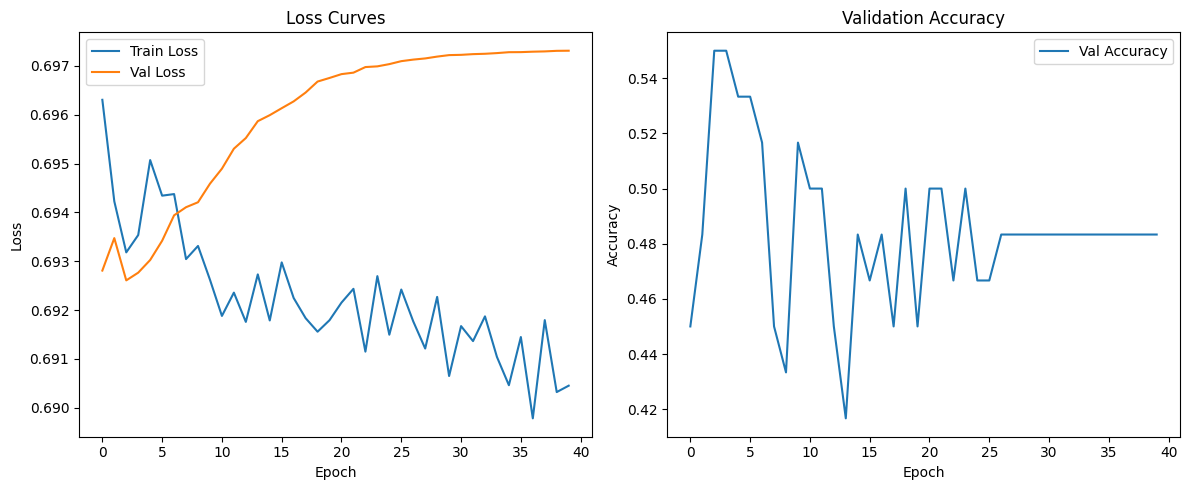

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()